# T-Maze Inference for Planning with GFE

This notebook reports the GFE for all policies for a variety of scenarios.

In [19]:
using Pkg
Pkg.activate(".");Pkg.instantiate();

  Activating project at `~/biaslab/repos/EpistemicMessagePassing/src/FLSimulations`


In [20]:
using LinearAlgebra
using ForneyLab
using Plots

import ForneyLab: collectNaiveVariationalNodeInbounds

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/GFECategorical.jl")
include("update_rules/GFECategorical.jl")
;

# Model

In [21]:
T = 2

fg = FactorGraph()

u = Vector{Variable}(undef, T)
x = Vector{Variable}(undef, T)

@RV x_t_min ~ Categorical(placeholder(:D_t_min, dims=(8,)))

x_k_min = x_t_min
for k=1:T
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k],id=:x_*k)

    placeholder(u[k], :u, index=k, dims=(8,8))
    GFECategorical(x[k], 
                   placeholder(:A, dims=(16,8), var_id=:A_*k), 
                   placeholder(:C, dims=(16,), index=k, var_id=:C_*k))
    
    x_k_min = x[k]
end
;

In [22]:
q = PosteriorFactorization(x_t_min,x[1],x[2], ids=[:x_t_min,:x_1,:x_2]);


In [23]:
q = PosteriorFactorization(fg)
algo = messagePassingAlgorithm(x, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(code))
;

# Results

In [24]:
# Reward probability and utility, uncomment scenario of interest
α = 0.9; c = 2.0

include("environment.jl")
include("agent.jl")
include("helpers.jl")

(A, B, C, D) = constructABCD(α, c)
;

## Constrained results

In [25]:
using ForneyLab: softmax #, unsafeMean, unsafeMode


C_t = [C, C]

n_its = 20
i,j = 4,2

# Evaluate all policies
F = zeros(4,4)
messages = Array{Message}(undef, 9)    

data = Dict(:u       => [B[i], B[j]],
            :A       => A,
            :C       => C_t,
            :D_t_min => D)

marginals = Dict{Symbol, ProbabilityDistribution}(
            :x_1 => ProbabilityDistribution(Univariate, Categorical, p=ones(8)./8),
            :x_2 => ProbabilityDistribution(Univariate, Categorical, p=ones(8)./8))

for i=1:n_its
            step!(data, marginals,messages)
end

F = freeEnergy(data, marginals)

F./log(2)#, messages # Convert to bits


36.088613559967094

In [26]:
marginals[:x_1]

Cat(p=[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.15, 0.15])


In [27]:
messages

9-element Vector{Message}:
 Message: Cat(p=[0.50, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00])

 Message: Cat(p=[0.06, 0.06, 0.42, 0.02, 0.02, 0.42, 1.56e-12, 3.83e-11])

 Message: Cat(p=[0.07, 0.07, 3.41e-12, 6.30e-13, 0.02, 0.53, 0.15, 0.15])

 Message: Cat(p=[6.16e-12, 1.81e-12, 6.16e-12, 1.81e-12, 0.04, 0.96, 6.16e-12, 1.81e-12])

 Message: Cat(p=[2.45e-12, 2.45e-12, 6.40e-12, 2.45e-12, 1.66e-03, 1.00, 2.45e-12, 2.45e-12])

 Message: Cat(p=[2.45e-12, 2.45e-12, 6.40e-12, 2.45e-12, 1.66e-03, 1.00, 2.45e-12, 2.45e-12])

 Message: Cat(p=[1.00e-12, 1.00e-12, 1.00e-12, 1.00e-12, 1.00e-12, 1.00e-12, 0.50, 0.50])

 Message: Cat(p=[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.73])

 Message: Cat(p=[1.00e-12, 1.00e-12, 0.11, 0.81, 0.04, 0.04, 1.00e-12, 1.00e-12])


In [28]:
messages[2]

Message: Cat(p=[0.06, 0.06, 0.42, 0.02, 0.02, 0.42, 1.56e-12, 3.83e-11])


In [29]:
messages[3]

Message: Cat(p=[0.07, 0.07, 3.41e-12, 6.30e-13, 0.02, 0.53, 0.15, 0.15])


In [30]:
messages[4]

Message: Cat(p=[6.16e-12, 1.81e-12, 6.16e-12, 1.81e-12, 0.04, 0.96, 6.16e-12, 1.81e-12])


In [31]:
marginals[:x_2]

Cat(p=[4.72e-11, 4.72e-11, 4.72e-11, 4.72e-11, 0.04, 0.96, 4.72e-11, 4.72e-11])


In [32]:
GFE = evaluatePolicies(A, B, C, D)


4×4 Matrix{Float64}:
 23.7329  25.7329  25.7329  23.7329
 20.6521  26.4606  15.2221  17.4234
 20.6521  15.2221  26.4606  17.4234
 25.6168  27.6168  27.6168  25.6168

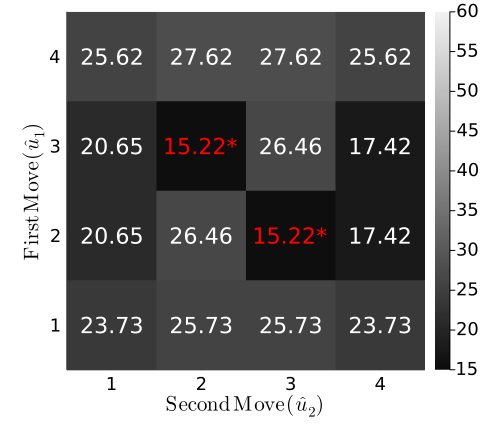

In [33]:
plotResults(GFE, clim=(15.0,60.0), dpi=300, highlight=minimum)
#savefig("figures/GFE_c_$(c)_a_$(α).png")

In [34]:
Meta.parse(code)

quote
    #= none:3 =#
    function step!(data::Dict, marginals::Dict = Dict(), messages::Vector{Message} = Array{Message}(undef, 9))
        #= none:3 =#
        #= none:5 =#
        messages[1] = ruleSPCategoricalOutNP(nothing, Message(Multivariate, PointMass, m = data[:D_t_min]))
        #= none:6 =#
        messages[2] = ruleSPGFECategoricalOutDPP(marginals[:x_1], Message(MatrixVariate, PointMass, m = data[:A]), Message(Multivariate, PointMass, m = (data[:C])[1]))
        #= none:7 =#
        messages[3] = ruleSPGFECategoricalOutDPP(marginals[:x_2], Message(MatrixVariate, PointMass, m = data[:A]), Message(Multivariate, PointMass, m = (data[:C])[2]))
        #= none:8 =#
        messages[4] = ruleSPTransitionIn1CNP(messages[3], nothing, Message(MatrixVariate, PointMass, m = (data[:u])[2]))
        #= none:9 =#
        messages[5] = ruleSPEqualityCategorical(nothing, messages[2], messages[4])
        #= none:10 =#
        messages[6] = ruleSPTransitionIn1CNP(messages[5], nothing, Mes

In [35]:
algo

InferenceAlgorithm(Symbol(""), PosteriorFactorization(FactorGraph(Dict{Symbol, FactorNode}(:placeholder_u_2 => Clamp{MatrixVariate} with id placeholder_u_2
, :x_2 => Transition with id x_2
, :x_1 => Transition with id x_1
, :placeholder_C_1 => Clamp{Multivariate} with id placeholder_C_1
, :equ_x_1_1 => Equality with id equ_x_1_1
, :placeholder_u_1 => Clamp{MatrixVariate} with id placeholder_u_1
, :gfecategorical_2 => GFECategorical with id gfecategorical_2
, :categorical_1 => Categorical with id categorical_1
, :gfecategorical_1 => GFECategorical with id gfecategorical_1
, :placeholder_A_1 => Clamp{MatrixVariate} with id placeholder_A_1
…), Edges:
Edge belonging to variable D_t_min: ( placeholder_D_t_min.i[out] )----( categorical_1.i[p] ).
Edge belonging to variable x_t_min: ( categorical_1.i[out] )----( x_1.i[in1] ).
Edge belonging to variable x_1: ( x_1.i[out] )----( equ_x_1_1.i[1] ).
Edge belonging to variable u_1: ( x_1.i[a] )----( placeholder_u_1.i[out] ).
Edge belonging to variab